In [ ]:
%%html
<script>
(function() {
  // Create the toggle button
  const rtlButton = document.createElement("button");
  rtlButton.textContent = "Toggle LTR";
  rtlButton.id = "top-rtl-toggle";
  rtlButton.style.marginLeft = "8px";
  rtlButton.style.padding = "4px 10px";
  rtlButton.style.fontSize = "14px";
  rtlButton.style.cursor = "pointer";

  // State
  var rtlActive = false;

  // Styling function
  var applyStyleToEditor = (editor) => {
    if (!editor) return;
    var direction = getComputedStyle(editor).getPropertyValue('direction')=='rtl' ? 'ltr' : 'rtl';
    var text_align = getComputedStyle(editor).getPropertyValue('text-align')=='right' ? 'left' : 'right';
    editor.style.setProperty('direction', direction, 'important');
    editor.style.setProperty('text-align', text_align, 'important');
  };

  // Toggle logic
  rtlButton.onclick = () => {
    rtlActive = !rtlActive;
    rtlButton.textContent = rtlActive ? "Toggle LTR" : "Toggle RTL";
    document.querySelectorAll('.jp-MarkdownCell .jp-InputArea-editor').forEach(applyStyleToEditor);
    document.querySelectorAll('.jp-RenderedHTMLCommon code, .jp-RenderedHTMLCommon code span').forEach(applyStyleToEditor);
    document.querySelectorAll('jp-RenderedHTMLCommon, .jp-RenderedHTMLCommon *').forEach(applyStyleToEditor);
  };

  // Watch for focus into editing Markdown cells
  // document.addEventListener('focusin', (event) => {
  //   const editor = event.target.closest('.jp-MarkdownCell .jp-InputArea-editor');
  //    if (editor) applyStyleToEditor(editor);
  // });

  // Insert into top toolbar if not already present
  var insertIntoToolbar = () => {
    const toolbar = document.querySelector('.jp-NotebookPanel-toolbar');
    if (toolbar && !document.getElementById("top-rtl-toggle")) {
      toolbar.appendChild(rtlButton);
    } else {
      // Try again in a moment if toolbar isn't ready yet
      setTimeout(insertIntoToolbar, 300);
    }
  };

  insertIntoToolbar();
})();
</script>

In [ ]:
%%html
<!-- <style>
  table {display: inline-block}
</style> -->

## Probabilities & Histograms

### מחולל אקראי מודרני

נשתמש בספריות NumPy ו-Matplotlib. נגדיר גם מחולל אקראי מודרני המאפשר שחזור של קוד על אף השימוש במספרים אקראיים (reproducibility).
מחולל מספרים "אקראיים" במחשב הוא למעשה **פסאודו-אקראי**: הוא מייצר רצף דטרמיניסטי. קביעת **seed** מגדירה את המצב ההתחלתי ולכן מבטיחה יכולת שחזור מלאה של הניסוי:
אותו seed ישחזר את אותו רצף  שיוביל לאותן תוצאות. 
זה קריטי למחקר חישובי: דיבוג, בדיקות יחידה, ביקורות עמיתים, והפעלות חוזרות.

```{note}
במחברת זאת נשתמש ב`default_rng` ממספר סיבות:
1. **בידוד מצב**:  `default_rng` יוצרת כל קריאה ל `Generator` ששומר מצב פנימי משלו. כך נמנע מיצירה של "מצב גלובלי" כמו ב-`np.random.seed`/`np.random` הישנים.
2. **יציבות**: קוד המשתמש ב-`Generator` צפוי יותר לאורך גרסאות, וקל יותר לשלוט בו.
3. **ממשק נקי**: פונקציות דגימה אחידות תחת `rng.*` (למשל `rng.normal`, `rng.poisson`, `rng.choice`).
```
כיצד נקבע seed?
- נקבע seed בראשית הקוד בפתיחה (למשל `seed=42`) כדי לאפשר שחזור.
- נקפיד **לא** לעשות re-seed בלולאה או בכל קריאה ,זה מאתחל את אותו הרצף שוב ושוב (באג נפוץ).
- העדיפו פונקציות שמקבלות `rng` כפרמטר — כך תכתבו קוד נקי מתלות גלובלית.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Modern RNG (prefer over legacy np.random.*)
rng = np.random.default_rng(seed=42)

np.__version__, "RNG OK"

('2.3.2', 'RNG OK')

## הסתברויות נפוצות

בעולם אמיתי מדידות ותרחישים רבים מושפעים מאקראיות: רעש חיישנים, דעיכה רדיואקטיבית, הגעת פוטונים לגלאי, תנודות תרמיות, זמני המתנה לאירוע, ועוד.  
במקום לתאר כל תוצאה בנפרד, מתארים את התופעה בעזרת **התפלגות הסתברות** — תבנית שמספרת כמה סביר לקבל ערכים שונים. בעזרת `NumPy` אפשר **לדגום** (להגריל) במהירות כמויות גדולות של נתונים לפי התפלגויות שונות, ולבדוק השערות/מודלים בצורה חישובית.

### מושגים בסיסיים (בקיצור)
- **משתנה מקרי**: גודל שערכו נקבע באקראי (למשל: מספר חלקיקים שנספר בשנייה).  
- **דיסקרטי** מול **רציף**: ערכים שלמים (0,1,2,…) לעומת רצף ממשי.  
- **PMF (Probability Mass funcion), PDF (Probability Distribution Function)**: פונקציית מסה (לדיסקרטי) / פונקציית צפיפות (לרציף) — מתארות “כמה סביר” כל ערך.  
- **CDF (Cumulative Distribution Function)**: פונקציה מצטברת $(F(x)=P(X\le x))$ — “כמה מתחת לסף”.  
- **תוחלת ושונות**: ממוצע “צפוי” ופיזור סביבו.  
- **היסטוגרמה**: קירוב אמפירי ל-PDF/CDF מתוך דגימות בפועל.


`````{admonition}  למה דווקא NumPy?
:class: tip
- **מהיר ווקטורי**: דוגמים ועובדים על מערכים שלמים בבת אחת (מאות אלפים ומיליונים של ערכים).  
- **מחולל אקראיות מודרני**: `numpy.random.Generator` מספק דגימה מהתפלגויות רבות (למשל `binomial`, `poisson`, `normal`, `exponential`, `uniform`, `geometric`).  
- **שיחזור תוצאות** (reproducibility): קובעים seed, למשל `rng = np.random.default_rng(42)`.
`````

`````{admonition} שימושים נפוצים לפיזיקאים
:class: tip
- **רעש מדידה וגאוסיאני**: מודלים עם התפלגות נורמלית $ \mathcal{N}(\mu,\sigma^2) $ לרעש חיישנים.  
- **ספירה של אירועים נדירים**: פואסון $ \text{Poisson}(\lambda) $ לתהליך דעיכה/ספירת פוטונים בזמן קבוע.  
- **ניסויים בעלי “הצלחה/כישלון”**: ברנולי/בינומי (יעילות גלאי, תשואה של שלב במערכת).  
- **זמני המתנה/חיי־ממוצע**: אקספוננציאלית $ \text{Exp}(\lambda) $ לזמן עד אירוע הבא.  
- **דיפוזיה/הליכה אקראית**: סכימת צעדים אקראיים → בזכות משפט הגבול המרכזי מתקבלת התפלגות נורמלית בקירוב.  
- **מונטה-קרלו**: סימולציה של מערכות מורכבות והערכת אינטגרלים/אי-ודאות ע"י דגימה מרובה.  
- **התאמת מודלים**: יצירת נתוני סימולציה להשוואה למדידה, הערכת פרמטרים ובדיקת רגישות.  
`````

`````{admonition} איך עובדים בפועל?
:class: tip
1. בוחרים מודל הסתברותי שמתאר את הפיזיקה (איזו התפלגות? אילו פרמטרים?).  
2. דוגמים נתונים עם `Generator` של NumPy.  
3. בונים **היסטוגרמה** ומשווים ל-PDF/CDF תיאורטיים.  
4. מחשבים סטטיסטיקות (ממוצע, שונות, אחוזונים) ובודקים האם המדידה תואמת למודל.  
5. חוזרים ומכוונים פרמטרים/השערות לפי הצורך.
`````

## היסטוגרמות  
**היסטוגרמה** היא אחד הכלים הבסיסיים ביותר לניתוח נתונים אמפיריים. היא מחלקת את ציר $x$ ל־*מחיצות* (bins), וסופרת כמה דגימות נופלות בכל מחיצה. כך מתקבלת תמונה ויזואלית של **פיזור הנתונים**: היכן הם מרוכזים, כמה הם מפוזרים, והאם יש "זנבות" או ערכים קיצוניים.  

![Alt text](https://plot.ly/static/img/literacy/fig3.gif)

כאשר מציבים את הפרמטר `density=True`, ההיסטוגרמה מנורמלת כך שסך השטח מתחת לעמודות שווה ל־1.  
במצב זה היא מהווה **קירוב ל־PDF** (פונקציית צפיפות הסתברות) עבור משתנים רציפים, או ל־PMF (פונקציית מסה הסתברותית) עבור משתנים בדידים.  
זה מאפשר להשוות בצורה ישירה בין נתונים אמפיריים לבין התפלגות תאורטית.  

`````{admonition} למה היסטוגרמות חשובות?
:class: tip
- מאפשרות **זיהוי צורת ההתפלגות**: האם היא סימטרית? גאוסיאנית? א־סימטרית?  
- מסייעות לגלות **ערכים חריגים** או פיזור רחב.  
- מאפשרות **השוואה בין ניסוי לתיאוריה** על ידי הנחת עקומה תאורטית מעל ההיסטוגרמה.  
- מהוות בסיס לחישוב **סטטיסטיקות אמפיריות** כמו הסתברויות משוערות (למשל: $P(X>1)$).  
`````

`````{admonition} בחירת מספר מחיצות (Bins)  
:class: tip
מספר מחיצות משפיע מאוד על המראה והאינפורמציה שבהיסטוגרמה:  
- מעט מדי מחיצות → האינפורמציה "נמרחת" ואיבדנו פרטים חשובים.  
- יותר מדי מחיצות → ההיסטוגרמה "רועשת" מדי וקשה לזהות דפוסים.  

אין כלל אחד "נכון", אבל קיימים כמה כללי אצבע שימושיים:  
- **שורש הדגימות**: $\sqrt{N}$ — מתן סדר גודל ראשוני.  
- **כלל Sturges**: $\lceil \log_2(N) + 1 \rceil$ — מתאים לדגימות שאינן ענקיות.  
- **כלל Freedman–Diaconis**:  
  - רוחב מחיצה: $h = 2 \cdot IQR \cdot N^{-1/3}$  
    (כאשר $IQR$ = הטווח הבין־רבעוני).  
  - מספר מחיצות: $\dfrac{\max - \min}{h}$.  
  כלל זה מתחשב בפיזור בפועל של הנתונים, ולכן לרוב נותן תוצאה מאוזנת יותר.  
`````

```{note}
- ב־NumPy קיימת הפונקציה `numpy.histogram` שמחזירה את מספר הספירות בכל מחיצה ואת גבולות המחיצות — שימושי לחישוב הסתברויות אמפיריות.  
- ב־Matplotlib קיימת `plt.hist` שמציירת את ההיסטוגרמה, ויכולה גם להחזיר את אותם נתונים.  
- במצבים מתקדמים יותר משתמשים גם בצפיפות קרנל (Kernel Density Estimation — KDE) שמחליקה את ההיסטוגרמה ויוצרת קירוב רציף יותר ל־PDF.  
```

לפני שנבחן מספר התפלגויות שונות, נבנה פונקציה `show_hist_with_theory` שתציג את ההיסטוגרמה לכל התפלגות:
פונקציה זו נועדה **להציג היסטוגרמה של נתונים אמפיריים** (כגון דגימות מתוך התפלגות אקראית)  
ובמקביל, אם נרצה, גם **להשוות לעקומה תיאורטית** (PDF רציף או PMF דיסקרטי).  


In [ ]:
# Common setup for all sections (Hebrew MD above; comments here are in English)
import numpy as np
import matplotlib.pyplot as plt
import math

# Global RNG for reproducibility
rng = np.random.default_rng(42)

def show_hist_with_theory(
    data,
    bins=40,
    density=True,
    title="",
    xlabel="",
    x_theory=None,
    y_theory=None,
    label_hist="Empirical (hist)",
    label_theory="Theory (PDF/PMF)"
):
    """Draw a histogram and overlay a theoretical curve/PMF with a legend."""
    plt.figure(figsize=(6, 4))
    plt.hist(data, bins=bins, density=density, label=label_hist)
    if (x_theory is not None) and (y_theory is not None):
        plt.plot(x_theory, y_theory, label=label_theory)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("density" if density else "count")
    plt.legend()
    plt.show()



#### פרמטרים עיקריים:
- `data` — מערך הדגימות שנרצה להציג.  
- `bins` — מספר או גבולות מחיצות (ברירת מחדל: 40).  
- `density` — אם `True`, ההיסטוגרמה מנורמלת כך שהשטח הכולל = 1 (חשוב להשוואה ל־PDF).  
- `title` — כותרת לגרף.  
- `xlabel` — תווית ציר X.  
- `x_theory, y_theory` — נקודות $(x,y)$ של פונקציה תיאורטית להשוואה (למשל PDF/PMF).  
- `label_hist` / `label_theory` — שמות שיוצגו במקרא (legend) עבור ההיסטוגרמה ועבור העקומה התיאורטית.

`````{admonition} מה הפונקציה עושה?
:class: tip
1. יוצרת חלון גרפי חדש עם `plt.figure`.  
2. מציירת את ההיסטוגרמה של הנתונים עם תווית `"Empirical (hist)"`.  
3. אם סופקו ערכים תיאורטיים (`x_theory`, `y_theory`) — מוסיפה קו תיאורטי עם תווית `"Theory"`.  
4. מוסיפה כותרת, תוויות צירים, ומקרא (legend).  
5. מציגה את התוצאה בעזרת `()plt.show`. 
`````

In [1]:
import json
from jupyterquiz import display_quiz

quiz_hist = \
'''
[{
  "question": "נתון וקטור של 10,000 דגימות מתוך התפלגות נורמלית סטנדרטית.<br><br>מה עושה הפקודה:<br><br>counts, bins = np.histogram(data, bins=30, density=True)",
  "type": "many_choice",
  "answers": [
    {
      "answer": "מחלקת את הנתונים ל־30 מחיצות ומחזירה את ספירת הדגימות בכל מחיצה (counts) ואת גבולות המחיצות (bins), מנורמלים כך שהשטח הכולל מתחת להיסטוגרמה שווה ל־1",
      "correct": true,
      "feedback": "נכון! עם density=True, np.histogram מנרמלת את התוצאה לקירוב ל־PDF"
    },
    {
      "answer": "מייצרת גרף היסטוגרמה על המסך",
      "correct": false,
      "feedback": "לא נכון — np.histogram רק מחזירה נתונים, הציור נעשה עם plt.hist"
    },
    {
      "answer": "מחלקת את הנתונים ל־30 ערכים שווים בגודל",
      "correct": false,
      "feedback": "לא נכון — bins מתארים טווחים רציפים, לא חלוקה לכמות שווה של נתונים"
    },
    {
      "answer": "מחזירה את הממוצע והשונות של הנתונים",
      "correct": false,
      "feedback": "לא נכון — np.histogram לא מחשבת סטטיסטיקות כאלה"
    }
  ]
}]
'''
myquiz = json.loads(quiz_hist)
display_quiz(myquiz)


<IPython.core.display.Javascript object>

### תיאוריה מול הדגמה אמפירית
הרעיון הוא לראות כיצד נתונים אקראיים אמיתיים שנדגמו מההתפלגות מתקרבים בצורה חזותית אל המודל המתמטי הצפוי.  
באמצעות ההשוואה הזו ניתן לפתח אינטואיציה: למשל, למה התפלגות פואסון מתארת היטב ספירה של אירועים נדירים בפרק זמן נתון, כיצד התפלגות נורמלית משקפת רעש מדידה הנובע מהמון גורמים זעירים ועצמאיים, או מדוע התפלגות אקספוננציאלית מתאימה לזמני המתנה בין אירועים אקראיים.

מעבר לאינטואיציה, ההדמיות מאפשרות גם להבין את ההבדל בין **התפלגות תאורטית** (שמוגדרת בנוסחה מתמטית מדויקת) לבין **דגימה אמפירית** (שבה תמיד יופיע רעש). ככל שמספר הדגימות גדל, ההיסטוגרמה מתקרבת יותר ויותר לעקומה התאורטית — המחשה ישירה של *חוק המספרים הגדולים*.

לצורך אחידות, נשתמש בפונקציית עזר אחת שתציג את ההיסטוגרמות עבור כל ההתפלגויות, ובמחולל אקראיות יחיד כדי לשמור על יכולת שחזור של אותן תוצאות (reproducibility). הדבר מאפשר גם להשוות בין הרצות שונות וגם לבדוק שינויים בפרמטרים באופן מבוקר.


#### Bernoulli — הצלחה/כישלון  
התפלגות ברנולי היא הבסיסית ביותר בעולם ההסתברויות. היא מתארת **ניסוי עם שתי תוצאות אפשריות בלבד**:  
- "הצלחה" (ערך 1) המתקבלת בהסתברות $p$.  
- "כישלון" (ערך 0) המתקבל בהסתברות $1-p$.  

אפשר לחשוב על זה כהטלת מטבע (עם או בלי הטיה): הצלחת "עץ" בהסתברות $p$, ותוצאה "פלי" בהסתברות $1-p$.  

`````{admonition} תכונות חשובות:
:class: tip
- **התוחלת**: $E[X] = p$ — כלומר בממוצע, אם נבצע הרבה ניסויים, שיעור ההצלחות יתקרב ל־$p$.  
- **השונות**: $Var[X] = p(1-p)$ — מודדת את הפיזור סביב התוחלת.  
`````
ההתפלגות הזו משמשת כבסיס להרבה התפלגויות אחרות (למשל בינומי, שמסכם מספר ניסיונות ברנולי).  
בפיזיקה ניתן להשתמש בה, לדוגמה, כדי לתאר האם חלקיק מסוים זוהה בגלאי (כן/לא) או האם מעבר אנרגיה התרחש.


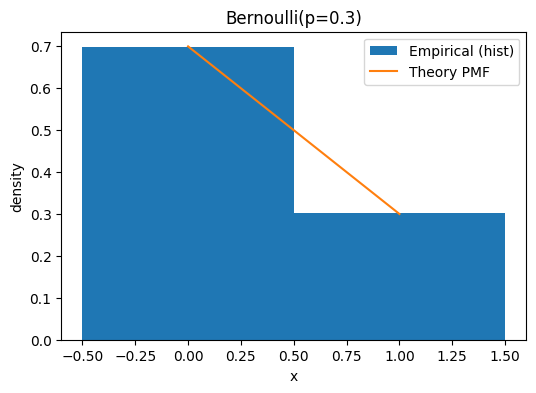

In [ ]:
# Bernoulli(p)
N = 50_000
p = 0.3
data = rng.binomial(n=1, p=p, size=N)

# Theoretical PMF points at x = 0, 1
x_th = [0, 1]
y_th = [1 - p, p]

show_hist_with_theory(
    data,
    bins=[-0.5, 0.5, 1.5],
    density=True,
    title=f"Bernoulli(p={p})",
    xlabel="x",
    x_theory=x_th, y_theory=y_th,
    label_hist="Empirical (hist)",
    label_theory="Theory PMF"
)

#### Binomial — מספר הצלחות מתוך $n$ ניסויים  

התפלגות בינומית מתארת את **מספר ההצלחות מתוך $n$ ניסויים בלתי־תלויים**, כאשר בכל ניסוי  
ההסתברות להצלחה היא אותה הסתברות $p$.  

אפשר לחשוב על זה כהרחבה של ברנולי: במקום ניסוי יחיד, אנו מבצעים סדרה של $n$ ניסויים (כמו $n$ הטלות מטבע).  
המשתנה המקרי $X$ הוא **כמה פעמים הצלחנו** מתוך $n$.  

`````{admonition} תכונות חשובות:
:class: tip
- **התוחלת**: $E[X] = np$ — מספר ההצלחות הצפוי מתוך $n$ ניסויים.  
- **השונות**: $Var[X] = np(1-p)$ — מדד הפיזור של מספר ההצלחות סביב התוחלת.  
`````

`````{admonition} דוגמאות שימוש:
:class: tip
- כמה חלקיקים יזוהו מתוך $n$ יריות אם ההסתברות שכל חלקיק ייקלט היא $p$.  
- כמה פוטונים יגיעו לגלאי מתוך סדרה של ניסיונות מדידה.  
- כמה ניסויים מוצלחים יהיו בניסוי פיזיקלי שחוזרים עליו מספר רב של פעמים.  
`````

הבינומי הוא אבן בניין מרכזית בסטטיסטיקה ובסימולציות מונטה־קרלו, כי הוא מאפשר להבין את הפיזור של הצלחות במספר גדול של ניסויים.


In [ ]:
# Binomial(n, p)
N = 50_000
n, p = 10, 0.3
data = rng.binomial(n=n, p=p, size=N)

# Theoretical PMF for k = 0..n
ks = np.arange(0, n + 1)
pmf = np.array([math.comb(n, k) * (p**k) * ((1 - p)**(n - k)) for k in ks])

show_hist_with_theory(
    data,
    bins=np.arange(-0.5, n + 1.5, 1),
    density=True,
    title=f"Binomial(n={n}, p={p})",
    xlabel="k",
    x_theory=ks, y_theory=pmf,
    label_theory="Theory PMF"
)


#### Geometric — מספר ניסיונות עד הצלחה ראשונה  

התפלגות גאומטרית מתארת את **מספר הניסיונות הדרושים עד להצלחה הראשונה**, כאשר בכל ניסיון  
הסיכוי להצלחה הוא $p$ והניסיונות בלתי־תלויים זה בזה.  

במילים אחרות: אנחנו שואלים *"כמה פעמים צריך לנסות עד שבפעם הראשונה נצליח?"*.  
המשתנה המקרי $X$ יכול לקבל ערכים $1, 2, 3, \dots$ — כי ההצלחה הראשונה יכולה להגיע כבר בניסיון הראשון,  
או בהמשך אחרי כמה כישלונות.  

`````{admonition} תכונות חשובות:
:class: tip
- **התוחלת**: $E[X] = \tfrac{1}{p}$ — בממוצע, נצטרך $1/p$ ניסיונות עד הצלחה.  
- **השונות**: $Var[X] = \tfrac{1-p}{p^2}$ — מדד הפיזור של מספר הניסיונות סביב התוחלת.  
`````

`````{admonition} דוגמאות שימוש:
:class: tip
- כמה פוטונים נצטרך לנסות למדוד עד שנקלוט אחד בגלאי בהסתברות $p$ לכל פוטון.  
- כמה ניסויי דעיכה רדיואקטיבית נצטרך עד שנצפה באירוע ראשון.  
- כמה ניסויים במעבדה עד לקבלת תוצאה רצויה (כמו התרחשות מעבר מסוים או תגובה כימית).  
`````

התפלגות זו מדגישה את רעיון ה"ניסיונות החוזרים" עד הצלחה ומופיעה רבות בפיזיקה סטטיסטית ובמודלים של תהליכים מקריים.


In [ ]:
# Geometric(p) — counts trials until first success (1,2,3,...)
N = 50_000
p = 0.25
data = rng.geometric(p, size=N)

# Display up to a reasonable cut for clarity
k_max = 15
ks = np.arange(1, k_max + 1)
pmf = p * (1 - p) ** (ks - 1)

show_hist_with_theory(
    data[data <= k_max],
    bins=np.arange(0.5, k_max + 1.5, 1),
    density=True,
    title=f"Geometric(p={p})",
    xlabel="k (trials to 1st success)",
    x_theory=ks, y_theory=pmf,
    label_theory="Theory PMF"
)


#### Poisson — ספירת אירועים בקצב ממוצע $\lambda$  

התפלגות פואסון מתארת את **מספר האירועים שמתרחשים בפרק זמן נתון או במרחב נתון**,  
כאשר האירועים מתרחשים באופן עצמאי ובקצב ממוצע קבוע $\lambda$.  

במילים אחרות: אם בממוצע מתרחשים $\lambda$ אירועים ביחידת זמן (או נפח/שטח),  
אז המשתנה המקרי $X$ אומר לנו *כמה אירועים התרחשו בפועל* ביחידת זמן מסוימת.  

`````{admonition} תכונות חשובות:
:class: tip
- **התוחלת**: $E[X] = \lambda$.  
- **השונות**: $Var[X] = \lambda$ — כלומר הפיזור שווה גם הוא לממוצע, תכונה ייחודית לפואסון.  
`````

`````{admonition} דוגמאות שימוש:
:class: tip
- מספר התפרקויות רדיואקטיביות שמתרחשות בשנייה במדגם חומר.  
- כמה פוטונים פוגעים בגלאי בזמן קצוב.  
- מספר התנגשות חלקיקים במאיץ בזמן חלון מדידה נתון.  
- ספירה של קרניים קוסמיות או חלקיקים נדירים הנמדדים ביחידות זמן.  
`````

הפואסון מהווה קירוב טבעי להתפלגות בינומית במצבים של מספר ניסויים גדול מאוד ($n \to \infty$)  
עם הסתברות הצלחה קטנה מאוד ($p \to 0$), כך ש־$np = \lambda$ נשאר קבוע.


In [ ]:
# Poisson(λ)
N = 50_000
lam = 3.5
data = rng.poisson(lam=lam, size=N)

# Theoretical PMF for k = 0..k_max
k_max = 15
ks = np.arange(0, k_max + 1)
pmf = np.exp(-lam) * lam**ks / np.array([math.factorial(k) for k in ks])

show_hist_with_theory(
    data,
    bins=np.arange(-0.5, k_max + 1.5, 1),
    density=True,
    title=f"Poisson(λ={lam})",
    xlabel="k",
    x_theory=ks, y_theory=pmf,
    label_theory="Theory PMF"
)


#### Uniform — אחידה רציפה בטווח $[a,b]$  

התפלגות אחידה רציפה היא אחת הפשוטות ביותר: היא מניחה שלכל ערך בטווח $[a,b]$ יש **הסתברות זהה להתרחש**.  
במילים אחרות, המשתנה המקרי $X$ מתפלג "בצורה שטוחה" — אין ערכים מועדפים יותר מאחרים.  

`````{admonition} פונקציית הצפיפות (PDF):
:class: tip

$$
f(x) = 
\begin{cases}
\frac{1}{b-a}, & a \le x \le b \\
0, & \text{otherwise}
\end{cases}
$$

`````

`````{admonition} תכונות חשובות:
:class: tip
- **התוחלת**: $E[X] = \tfrac{a+b}{2}$ — הערך הממוצע הוא בדיוק האמצע של הטווח.  
- **השונות**: $Var[X] = \tfrac{(b-a)^2}{12}$ — הפיזור תלוי ברוחב הטווח.  
`````

`````{admonition} דוגמאות שימוש:
:class: tip
- מודל פשוט לשגיאת מדידה שאינה תלויה בערך (טעות אחידה בטווח מסוים).  
- בחירה מקרית של נקודה על מקטע.  
- סימולציות מונטה־קרלו שבהן מתחילים מדגימה אחידה ולאחר מכן ממירים להתפלגות אחרת.  
`````

התפלגות זו משמשת כבסיס להרבה מחוללי מספרים אקראיים — לרוב מייצרים מספרים אחידים ב־$[0,1]$,  
ומהם בונים דגימות מכל התפלגות אחרת.


In [ ]:
# Uniform(a, b)
N = 50_000
a, b = -2, 3
data = rng.uniform(a, b, size=N)

# Theoretical PDF is constant on [a,b]
xs = np.linspace(a, b, 300)
pdf = np.ones_like(xs) / (b - a)

show_hist_with_theory(
    data,
    bins=40,
    density=True,
    title=f"Uniform({a}, {b})",
    xlabel="x",
    x_theory=xs, y_theory=pdf,
    label_theory="Theory PDF"
)


#### Normal — נורמלית $ \mathcal{N}(\mu,\sigma^2) $  

התפלגות נורמלית (או "גאוסיאנית") היא אחת ההתפלגויות החשובות והנפוצות ביותר במדע.  
היא מתוארת ע"י **פעמון סימטרי** סביב התוחלת $\mu$, עם פרמטר סטיית תקן $\sigma$ שמגדיר את רוחב הפעמון.  

`````{admonition} פונקציית הצפיפות (PDF):
:class: tip

$$
f(x) = \frac{1}{\sigma\sqrt{2\pi}} \exp\!\left( -\frac{(x-\mu)^2}{2\sigma^2} \right)
$$

`````

`````{admonition} תכונות חשובות:
:class: tip
- **התוחלת**: $E[X] = \mu$ — מרכז הפעמון.  
- **השונות**: $Var[X] = \sigma^2$ — קובעת את הפיזור סביב התוחלת.  
- **התפלגות סימטרית**: חציון ושכיח שווים גם הם ל־$\mu$.  
`````

`````{admonition} דוגמאות שימוש:
:class: tip
- רעש מדידה — טעויות מקריות נוטות להתפלג נורמלית סביב הערך האמיתי.  
- תופעות טבע רבות מתכנסות לנורמלית בזכות **משפט הגבול המרכזי** (חיבור של הרבה משתנים אקראיים בלתי־תלויים).  
- מהירות חלקיקים בגז (מודל מקסוול־בולצמן) מתוארת בנגזרת של התפלגות נורמלית.  
`````

הנורמלית היא אבן יסוד בסטטיסטיקה ובפיזיקה סטטיסטית, ומשמשת בסיס להסקת מסקנות ולבניית מודלים.


In [ ]:
# Normal(μ, σ)
N = 50_000
mu, sigma = 0.0, 1.0
data = rng.normal(mu, sigma, size=N)

# Theoretical PDF of Normal
xs = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 400)
pdf = (1.0 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((xs - mu) / sigma) ** 2)

show_hist_with_theory(
    data,
    bins=40,
    density=True,
    title=f"Normal(μ={mu}, σ={sigma})",
    xlabel="x",
    x_theory=xs, y_theory=pdf,
    label_theory="Theory PDF"
)


#### Exponential — זמן בין אירועים בקצב $\lambda$  

התפלגות אקספוננציאלית מתארת את **הזמן שחולף בין שני אירועים עוקבים** בתהליך פואסוני, כלומר תהליך שבו אירועים מתרחשים בקצב ממוצע קבוע $\lambda$ ובאופן בלתי־תלוי.  

`````{admonition} פונקציית הצפיפות (PDF):
:class: tip

$$
f(x) = 
\begin{cases}
\lambda e^{-\lambda x}, & x \ge 0 \\
0, & x < 0
\end{cases}
$$

`````

`````{admonition} תכונות חשובות:
:class: tip
- **התוחלת**: $E[X] = \tfrac{1}{\lambda}$ — הזמן הממוצע בין אירועים.  
- **השונות**: $Var[X] = \tfrac{1}{\lambda^2}$ — הפיזור סביב התוחלת.  
- **תכונת "חוסר הזיכרון"**: ההסתברות להתרחשות אירוע אינה תלויה בזמן שעבר מאז האירוע הקודם.  
`````

`````{admonition} דוגמאות שימוש:
:class: tip
- זמן חיים של אטום מעורר לפני דעיכה רדיואקטיבית.  
- זמן המתנה עד שחלקיק יפגע בגלאי.  
- זמני כשל (failure times) של רכיבים אלקטרוניים במודל פשוט.  
- זמני המתנה במודלים של תורים (Queueing theory).  
`````

האקספוננציאלית היא מרכיב בסיסי במודלים של תהליכים מקריים מתמשכים ובפיזיקה סטטיסטית, והיא משמשת גם כבסיס לבניית התפלגויות אחרות (למשל גאמא).


In [ ]:
# Exponential(λ)
N = 50_000
lam = 0.5
data = rng.exponential(scale=1 / lam, size=N)  # NumPy uses 'scale' = 1/λ

# Plot theoretical PDF on a practical x-range
xmax = np.quantile(data, 0.995)
xs = np.linspace(0, xmax, 400)
pdf = lam * np.exp(-lam * xs)

show_hist_with_theory(
    data,
    bins=40,
    density=True,
    title=f"Exponential(λ={lam})",
    xlabel="x",
    x_theory=xs, y_theory=pdf,
    label_theory="Theory PDF"
)


In [ ]:
import json
from jupyterquiz import display_quiz

quiz_numpy_dists = \
'''
[{
  "question": "איזו פקודה ב-NumPy מתאימה לדגימה מניסוי ברנולי עם הסתברות הצלחה p=0.3?",
  "type": "many_choice",
  "answers": [
    {
      "answer": "rng.binomial(n=1, p=0.3, size=1000)",
      "correct": true,
      "feedback": "נכון! דגימת ברנולי נעשית כבינומי עם n=1"
    },
    {
      "answer": "rng.bernoulli(p=0.3, size=1000)",
      "correct": false,
      "feedback": "לא נכון — ב-NumPy אין פונקציה bernoulli נפרדת, אלא binomial עם n=1"
    },
    {
      "answer": "rng.normal(0.3, 1, size=1000)",
      "correct": false,
      "feedback": "לא נכון — זה מגריל התפלגות נורמלית, לא ברנולי"
    },
    {
      "answer": "rng.poisson(0.3, size=1000)",
      "correct": false,
      "feedback": "לא נכון — זו התפלגות פואסון"
    }
  ]
},
{
  "question": "איך נדגום מספר הצלחות מתוך 20 ניסיונות בהסתברות הצלחה p=0.1 בעזרת NumPy?",
  "type": "many_choice",
  "answers": [
    {
      "answer": "rng.binomial(n=20, p=0.1, size=5000)",
      "correct": true,
      "feedback": "נכון! binomial עם n=20 מתאר בדיוק את המקרה הזה"
    },
    {
      "answer": "rng.geometric(p=0.1, size=5000)",
      "correct": false,
      "feedback": "לא נכון — geometric מחזירה את מספר הניסיונות עד הצלחה ראשונה"
    },
    {
      "answer": "rng.poisson(20*0.1, size=5000)",
      "correct": false,
      "feedback": "זה יכול לשמש כקירוב במקרים מסוימים, אך ההגדרה המדויקת היא binomial"
    },
    {
      "answer": "rng.uniform(0,20, size=5000)",
      "correct": false,
      "feedback": "לא נכון — uniform מגרילה ערכים אחידים, לא הצלחות מתוך ניסיונות"
    }
  ]
},
{
  "question": "נרצה לדגם זמני המתנה עד לאירוע בתהליך בקצב λ=2. איזו פקודה ב-NumPy מתאימה?",
  "type": "many_choice",
  "answers": [
    {
      "answer": "rng.exponential(scale=1/2, size=10000)",
      "correct": true,
      "feedback": "נכון! scale = 1/λ בדגימה אקספוננציאלית ב-NumPy"
    },
    {
      "answer": "rng.poisson(2, size=10000)",
      "correct": false,
      "feedback": "לא נכון — זו דוגמת פואסון שמתארת ספירת אירועים, לא זמן המתנה"
    },
    {
      "answer": "rng.normal(2,1,size=10000)",
      "correct": false,
      "feedback": "לא נכון — נורמלית אינה מתארת זמני המתנה"
    },
    {
      "answer": "rng.binomial(n=2,p=0.5,size=10000)",
      "correct": false,
      "feedback": "לא נכון — זו התפלגות בינומית"
    }
  ]
}]
'''
myquiz = json.loads(quiz_numpy_dists)
display_quiz(myquiz)


<IPython.core.display.Javascript object>